
# Import packages

In [1]:
import sys
import pandas as pd
import numpy as np
import glob
import os
import matplotlib.pyplot as plt

import tqdm

sys.path.append('../../')
from utils import dataframe_utils

In [2]:
import bokeh.io
import bokeh.plotting
import bokeh.models
import bokeh.transform

# Import the data for each timepoint

In [3]:
file_paths = sorted(glob.glob('../../input_data/kallisto_data_folders/kallisto_quant_p_trimmed_*'))
file_paths

['../../input_data/kallisto_data_folders/kallisto_quant_p_trimmed_000min_A',
 '../../input_data/kallisto_data_folders/kallisto_quant_p_trimmed_000min_B',
 '../../input_data/kallisto_data_folders/kallisto_quant_p_trimmed_030min_A',
 '../../input_data/kallisto_data_folders/kallisto_quant_p_trimmed_030min_B',
 '../../input_data/kallisto_data_folders/kallisto_quant_p_trimmed_060min_A',
 '../../input_data/kallisto_data_folders/kallisto_quant_p_trimmed_060min_B',
 '../../input_data/kallisto_data_folders/kallisto_quant_p_trimmed_090min_A',
 '../../input_data/kallisto_data_folders/kallisto_quant_p_trimmed_090min_B',
 '../../input_data/kallisto_data_folders/kallisto_quant_p_trimmed_120min_A',
 '../../input_data/kallisto_data_folders/kallisto_quant_p_trimmed_120min_B',
 '../../input_data/kallisto_data_folders/kallisto_quant_p_trimmed_150min_A',
 '../../input_data/kallisto_data_folders/kallisto_quant_p_trimmed_150min_B',
 '../../input_data/kallisto_data_folders/kallisto_quant_p_trimmed_180min_A',

In [4]:
dict_tpms = {}

for fp in file_paths:
    split = ((os.path.splitext(os.path.basename(fp))[0]).split('_'))
    key = '_'.join(split[len(split)-2:len(split)])
    print(key)
    dict_tpms[key] = (pd.read_csv(os.path.join(fp, 'abundance.tsv'), delimiter='\t'))

print(np.unique([df.shape for df in dict_tpms.values()]))

000min_A
000min_B
030min_A
030min_B
060min_A
060min_B
090min_A
090min_B
120min_A
120min_B
150min_A
150min_B
180min_A
180min_B
210min_A
210min_B
240min_A
240min_B
[    5 26687]


In [5]:
dict_tpms['000min_A'].head()

,target_id,length,eff_length,est_counts,tpm
0,TTHERM_00161861,420,234.021,12.0,0.494446
1,TTHERM_00161860,4356,4167.380,11088.0,25.655600
2,TTHERM_00161850,1200,1011.380,102.0,0.972475
3,TTHERM_00161840,498,310.211,907.0,28.193000
4,TTHERM_00161830,1077,888.377,1320.0,14.327400


In [6]:
def computeRPK(row):
    if not row['eff_length'] > 0:
        print('ZERO sequence length:', row['target_id'])
        print(row)
        return 'ZERO sequence length'
    return row['est_counts']/row['eff_length']

def computeTPM(row, normalization_factor):
    return row['rpk']/normalization_factor

def compute_tpm_columns(df_dict):
    df_tpm = {}
    normalization_factor_dict = {}
    for key, df in df_dict.items():
        tpm_df = df
        tpm_df['rpk'] = tpm_df.apply(computeRPK, axis=1)
        tpm_df = tpm_df.loc[tpm_df['rpk']!='ZERO sequence length']

        sum_rpk = tpm_df['rpk'].sum()

        normalization_factor = sum_rpk/1_000_000

        tpm_df['tpm_manual'] = tpm_df.apply(computeTPM, axis=1, args=(normalization_factor,))

        df_tpm[key] = tpm_df  
        normalization_factor_dict[key] = normalization_factor

    return df_tpm, normalization_factor_dict

def compute_cpm_columns(df_dict):
    df_cpm = {}
    for key, df in df_dict.items():
        cpm_df = df

        sum_count = cpm_df['est_counts'].sum()

        cpm_df['cpm_manual'] = (cpm_df['est_counts'] / sum_count) * 1_000_000

        df_cpm[key] = cpm_df  

    return df_cpm

In [7]:
dict_tpms, norm_factors_dict = compute_tpm_columns(dict_tpms)

In [8]:
dict_tpms['150min_A'].head()

,target_id,length,eff_length,est_counts,tpm,rpk,tpm_manual
0,TTHERM_00161861,420,237.091,10.0,0.464797,0.042178,0.464797
1,TTHERM_00161860,4356,4170.270,14919.0,39.423300,3.577466,39.423350
2,TTHERM_00161850,1200,1014.270,1122.0,12.190400,1.106214,12.190380
3,TTHERM_00161840,498,313.435,1276.0,44.862300,4.071020,44.862262
4,TTHERM_00161830,1077,891.270,1585.0,19.597400,1.778361,19.597378


In [9]:
dict_cpms = compute_cpm_columns(dict_tpms)

In [10]:
dict_cpms['150min_A'].head()

,target_id,length,eff_length,est_counts,tpm,rpk,tpm_manual,cpm_manual
0,TTHERM_00161861,420,237.091,10.0,0.464797,0.042178,0.464797,0.202593
1,TTHERM_00161860,4356,4170.270,14919.0,39.423300,3.577466,39.423350,302.248006
2,TTHERM_00161850,1200,1014.270,1122.0,12.190400,1.106214,12.190380,22.730898
3,TTHERM_00161840,498,313.435,1276.0,44.862300,4.071020,44.862262,25.850825
4,TTHERM_00161830,1077,891.270,1585.0,19.597400,1.778361,19.597378,32.110938


In [11]:
norm_factors_dict

{'000min_A': 0.1037070326424425,
 '000min_B': 0.11857840271950969,
 '030min_A': 0.10993092399697786,
 '030min_B': 0.10524329474002664,
 '060min_A': 0.10363163917643455,
 '060min_B': 0.12963020406668638,
 '090min_A': 0.0952828245820684,
 '090min_B': 0.11038255683949492,
 '120min_A': 0.09625930761158062,
 '120min_B': 0.11952187127800394,
 '150min_A': 0.09074485643941699,
 '150min_B': 0.11275799305552293,
 '180min_A': 0.10914940225442674,
 '180min_B': 0.10916250389631336,
 '210min_A': 0.0825653695429961,
 '210min_B': 0.10398363852428015,
 '240min_A': 0.11956682547853985,
 '240min_B': 0.11169527770156734}

In [12]:
dict_tpms['000min_A'].shape

(26687, 8)

## Checkout a single timepoint

In [13]:
num_nonzero = (dict_tpms['000min_A'].loc[dict_tpms['000min_A']['tpm'] != 0.0].shape)[0]

mean = dict_tpms['000min_A']['tpm'].mean()

std = dict_tpms['000min_A']['tpm'].std()

str_summary_wzeros = f'''WITH ZEROS...
MEAN: {mean}
MEDIAN: {dict_tpms['000min_A']['tpm'].median()}
STDEV: {std}
CV: {(std/mean)*100}
MAX: {dict_tpms['000min_A']['tpm'].max()}
MIN: {dict_tpms['000min_A']['tpm'].min()}
# GENES EXPRESSED: {num_nonzero}
'''

df_tpm_wozeros = dict_tpms['000min_A'].loc[dict_tpms['000min_A']['tpm'] != 0.0]

mean_wozeros = df_tpm_wozeros['tpm'].mean()

std_wozeros = df_tpm_wozeros['tpm'].std()

str_summary_wozeros = f'''WITHOUT ZEROS...
MEAN: {mean_wozeros}
MEDIAN: {df_tpm_wozeros['tpm'].median()}
STDEV: {std_wozeros}
CV: {(std_wozeros/mean_wozeros)*100}
MAX: {df_tpm_wozeros['tpm'].max()}
MIN: {df_tpm_wozeros['tpm'].min()}
# GENES EXPRESSED: {num_nonzero}
'''

print(str_summary_wzeros, '\n', str_summary_wozeros, sep='')


WITH ZEROS...
MEAN: 37.47142659130371
MEDIAN: 0.815177
STDEV: 385.9761602256753
CV: 1030.05461851098
MAX: 28942.1
MIN: 0.0
# GENES EXPRESSED: 23539

WITHOUT ZEROS...
MEAN: 42.482686666473604
MEDIAN: 1.23647
STDEV: 410.7178296710274
CV: 966.7887365399533
MAX: 28942.1
MIN: 1.59363e-08
# GENES EXPRESSED: 23539



# Create a dataframe containing all data at every timepoint (sorted by TTHERM_ID)

In [14]:
column_prefixes = sorted(list(dict_tpms.keys()))
column_prefixes

['000min_A',
 '000min_B',
 '030min_A',
 '030min_B',
 '060min_A',
 '060min_B',
 '090min_A',
 '090min_B',
 '120min_A',
 '120min_B',
 '150min_A',
 '150min_B',
 '180min_A',
 '180min_B',
 '210min_A',
 '210min_B',
 '240min_A',
 '240min_B']

In [15]:
complete_data_df = None

for col_prefix in column_prefixes:
    curr_df = dict_tpms[col_prefix].sort_values(by='target_id')
    curr_df.rename(columns={col: (f'{col_prefix}_{col}') for col in list(curr_df.columns) if col != 'target_id'}, inplace=True)

    if complete_data_df is None:
        complete_data_df = curr_df
        continue

    complete_data_df = dataframe_utils.sql_query_df({'complete_data_df': complete_data_df, 'curr_df': curr_df},
                                                    '''SELECT * FROM complete_data_df
                                                       INNER JOIN curr_df USING(target_id)'''
                                                    )

complete_data_df.rename(columns={'target_id': 'TTHERM_ID'}, inplace=True)
complete_data_df


,TTHERM_ID,000min_A_length,000min_A_eff_length,000min_A_est_counts,000min_A_tpm,000min_A_rpk,000min_A_tpm_manual,000min_A_cpm_manual,000min_B_length,000min_B_eff_length,...,240min_A_rpk,240min_A_tpm_manual,240min_A_cpm_manual,240min_B_length,240min_B_eff_length,240min_B_est_counts,240min_B_tpm,240min_B_rpk,240min_B_tpm_manual,240min_B_cpm_manual
0,TTHERM_00000010,1587,1398.380,347.0000,2.392750,0.248144,2.392743,6.176870,1587,1400.310,...,0.057392,0.480000,1.299130,1587,1397.010,86.0000,0.551144,0.061560,0.551143,1.502907
1,TTHERM_00000020,1665,1476.380,10.0000,0.065312,0.006773,0.065312,0.178008,1665,1478.310,...,0.029893,0.250010,0.714522,1665,1475.010,13.0000,0.078907,0.008813,0.078907,0.227184
2,TTHERM_00000030,1887,1698.380,54.0000,0.306585,0.031795,0.306585,0.961242,1887,1700.310,...,0.002952,0.024687,0.081196,1887,1697.010,2.0000,0.010551,0.001179,0.010551,0.034951
3,TTHERM_00000031,360,176.970,0.0000,0.000000,0.000000,0.000000,0.000000,360,178.737,...,0.000000,0.000000,0.000000,360,175.787,0.0000,0.000000,0.000000,0.000000,0.000000
4,TTHERM_00000040,2958,2769.380,644.0000,2.242310,0.232543,2.242307,11.463702,2958,2771.310,...,0.211941,1.772574,9.516130,2958,2768.010,668.0000,2.160600,0.241329,2.160598,11.673741
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26682,TTHERM_02653514,924,735.377,0.0000,0.000000,0.000000,0.000000,0.000000,924,737.306,...,0.000000,0.000000,0.000000,924,734.006,0.0000,0.000000,0.000000,0.000000,0.000000
26683,TTHERM_02653516,897,708.377,77.0157,1.048350,0.108721,1.048351,1.370939,897,710.306,...,0.068218,0.570546,0.779808,897,707.006,51.0228,0.646110,0.072167,0.646110,0.891657
26684,TTHERM_02653518,1443,1254.380,186.3350,1.432380,0.148547,1.432376,3.316908,1443,1256.310,...,0.144849,1.211450,2.940094,1443,1253.010,163.0530,1.165040,0.130129,1.165036,2.849459
26685,TTHERM_06324284,1797,1608.380,285.1850,1.709740,0.177312,1.709739,5.076515,1797,1610.310,...,0.155302,1.298872,4.045037,1797,1607.010,247.1160,1.376730,0.153774,1.376726,4.318515


In [16]:
# 10 reads cuttoff
complete_data_df['max_count'] = complete_data_df[[col for col in complete_data_df if 'counts' in col]].apply(lambda x: max(x), axis=1)

In [17]:
complete_data_df_filtered = complete_data_df.loc[complete_data_df['max_count'] > 10]
complete_data_df_filtered

,TTHERM_ID,000min_A_length,000min_A_eff_length,000min_A_est_counts,000min_A_tpm,000min_A_rpk,000min_A_tpm_manual,000min_A_cpm_manual,000min_B_length,000min_B_eff_length,...,240min_A_tpm_manual,240min_A_cpm_manual,240min_B_length,240min_B_eff_length,240min_B_est_counts,240min_B_tpm,240min_B_rpk,240min_B_tpm_manual,240min_B_cpm_manual,max_count
0,TTHERM_00000010,1587,1398.3800,347.0000,2.392750,0.248144,2.392743,6.176870,1587,1400.3100,...,0.480000,1.299130,1587,1397.0100,86.0000,0.551144,0.061560,0.551143,1.502907,450.0000
1,TTHERM_00000020,1665,1476.3800,10.0000,0.065312,0.006773,0.065312,0.178008,1665,1478.3100,...,0.250010,0.714522,1665,1475.0100,13.0000,0.078907,0.008813,0.078907,0.227184,44.0000
2,TTHERM_00000030,1887,1698.3800,54.0000,0.306585,0.031795,0.306585,0.961242,1887,1700.3100,...,0.024687,0.081196,1887,1697.0100,2.0000,0.010551,0.001179,0.010551,0.034951,54.0000
4,TTHERM_00000040,2958,2769.3800,644.0000,2.242310,0.232543,2.242307,11.463702,2958,2771.3100,...,1.772574,9.516130,2958,2768.0100,668.0000,2.160600,0.241329,2.160598,11.673741,833.0000
5,TTHERM_00000047,2505,2316.3800,30.0000,0.124883,0.012951,0.124883,0.534023,2505,2318.3100,...,0.209819,0.941870,2505,2315.0100,161.0000,0.622642,0.069546,0.622642,2.813581,480.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26680,TTHERM_02653503,270,98.3352,10.0000,0.980579,0.101693,0.980579,0.178008,270,99.5949,...,2.277956,0.422217,270,97.4345,34.0000,3.124150,0.348952,3.124146,0.594172,73.0000
26681,TTHERM_02653508,1341,1152.3800,1037.2800,8.679450,0.900120,8.679448,18.464392,1341,1154.3100,...,9.153888,20.402843,1341,1151.0100,1285.3200,9.997680,1.116689,9.997637,22.461816,2518.8600
26683,TTHERM_02653516,897,708.3770,77.0157,1.048350,0.108721,1.048351,1.370939,897,710.3060,...,0.570546,0.779808,897,707.0060,51.0228,0.646110,0.072167,0.646110,0.891657,83.0674
26684,TTHERM_02653518,1443,1254.3800,186.3350,1.432380,0.148547,1.432376,3.316908,1443,1256.3100,...,1.211450,2.940094,1443,1253.0100,163.0530,1.165040,0.130129,1.165036,2.849459,186.3350


In [18]:
tidy_df_data = complete_data_df.melt(var_name='replicate', value_name='counts', id_vars='TTHERM_ID')
tidy_df_data['replicate'] = [r[:8] for r in tidy_df_data['replicate'].values]
tidy_df_data.head()

,TTHERM_ID,replicate,counts
0,TTHERM_00000010,000min_A,1587.0
1,TTHERM_00000020,000min_A,1665.0
2,TTHERM_00000030,000min_A,1887.0
3,TTHERM_00000031,000min_A,360.0
4,TTHERM_00000040,000min_A,2958.0


In [19]:
len(tidy_df_data)

3389249

In [20]:
def expression_jitter_plot(
    tidy_df, 
    alpha=0.1, 
    y_axis_type='log', 
    title=None, 
    y_max=1e6, 
    width=600, 
    jitter_width=0.6,
    y_axis_label=None,
    x_axis_label=None
):

    factors = sorted(list(tidy_df['replicate'].unique()))

    if 'color' not in tidy_df.columns:
        tidy_df['color'] = 'blue'
        tidy_df['label'] = 'kept'

    kept_source = bokeh.models.ColumnDataSource(tidy_df.loc[tidy_df['label'] == 'kept'])
    lost_source = bokeh.models.ColumnDataSource(tidy_df.loc[tidy_df['label'] == 'lost'])
    
    expr_fig = bokeh.plotting.figure(
        height=400,
        width=width,
        x_range=factors,
        y_range=bokeh.models.Range1d(1e-11, y_max),
        y_axis_type=y_axis_type,
        title=title,
        y_axis_label=y_axis_label,
        x_axis_label=x_axis_label
    )
    
    expr_fig.scatter(
        x=bokeh.transform.jitter('replicate', width=jitter_width, range=expr_fig.x_range), 
        y='counts', 
        source=kept_source,
        alpha=alpha,
        color='color',
        # legend_group='label'
    )

    expr_fig.scatter(
        x=bokeh.transform.jitter('replicate', width=jitter_width, range=expr_fig.x_range), 
        y='counts', 
        source=lost_source,
        alpha=alpha,
        color='color',
        # legend_group='label'
    )
    
    expr_fig.xaxis.major_label_orientation = np.pi/2
    # expr_fig.legend.location = 'bottom_right'

    # expr_fig.output_backend = 'webgl'

    return expr_fig

In [21]:
# unfiltered_jitter = expression_jitter_plot(tidy_df_data, title='Unfiltered counts')

In [22]:
# bokeh.io.show(unfiltered_jitter)

# Create a dataframe containing all TPM data at every timepoint (sorted by TTHERM_ID)

In [23]:
columns = sorted(list(dict_tpms.keys()))
columns

['000min_A',
 '000min_B',
 '030min_A',
 '030min_B',
 '060min_A',
 '060min_B',
 '090min_A',
 '090min_B',
 '120min_A',
 '120min_B',
 '150min_A',
 '150min_B',
 '180min_A',
 '180min_B',
 '210min_A',
 '210min_B',
 '240min_A',
 '240min_B']

In [24]:
curr_df = dict_tpms['000min_A'].sort_values(by='target_id')
dict_df_all_tpm = {'TTHERM_ID': curr_df['target_id'].values}
print(curr_df.head(3))

for col in columns:
    curr_df = dict_tpms[col].sort_values(by='target_id')
    print(curr_df.head(3))
    dict_df_all_tpm[col] = (curr_df)['tpm'].values

df_all_tpm = pd.DataFrame(dict_df_all_tpm)

print(df_all_tpm.shape)

df_all_tpm.head()

            target_id  length  eff_length  est_counts       tpm       rpk  \
9250  TTHERM_00000010    1587     1398.38       347.0  2.392750  0.248144   
9249  TTHERM_00000020    1665     1476.38        10.0  0.065312  0.006773   
9248  TTHERM_00000030    1887     1698.38        54.0  0.306585  0.031795   

      tpm_manual  cpm_manual  
9250    2.392743    6.176870  
9249    0.065312    0.178008  
9248    0.306585    0.961242  
            target_id  length  eff_length  est_counts       tpm       rpk  \
9250  TTHERM_00000010    1587     1398.38       347.0  2.392750  0.248144   
9249  TTHERM_00000020    1665     1476.38        10.0  0.065312  0.006773   
9248  TTHERM_00000030    1887     1698.38        54.0  0.306585  0.031795   

      tpm_manual  cpm_manual  
9250    2.392743    6.176870  
9249    0.065312    0.178008  
9248    0.306585    0.961242  
            target_id  length  eff_length  est_counts       tpm       rpk  \
9250  TTHERM_00000010    1587     1400.31       118.0  0.

,TTHERM_ID,000min_A,000min_B,030min_A,030min_B,060min_A,060min_B,090min_A,090min_B,120min_A,120min_B,150min_A,150min_B,180min_A,180min_B,210min_A,210min_B,240min_A,240min_B
0,TTHERM_00000010,2.392750,0.710646,2.936400,1.481740,0.552868,0.531153,0.187647,0.396045,0.230034,0.328534,0.314569,0.348150,0.453546,0.433522,0.365727,0.498008,0.480000,0.551144
1,TTHERM_00000020,0.065312,0.017114,0.105053,0.025751,0.065452,0.068116,0.092421,0.006149,0.126519,0.045266,0.111743,0.029981,0.031124,0.068427,0.090699,0.052395,0.250010,0.078907
2,TTHERM_00000030,0.306585,0.029759,0.021479,0.000000,0.000000,0.009106,0.024720,0.026718,0.012222,0.014759,0.019432,0.010427,0.010818,0.027029,0.028651,0.005689,0.024687,0.010551
3,TTHERM_00000031,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.046630,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,TTHERM_00000040,2.242310,2.534870,1.450830,1.602540,1.701660,1.871890,1.807760,2.014030,2.020740,2.218700,2.186280,2.399470,1.938510,2.398120,1.824270,1.925910,1.772570,2.160600


In [25]:
all_cols = list(df_all_tpm.columns)
all_cols

['TTHERM_ID',
 '000min_A',
 '000min_B',
 '030min_A',
 '030min_B',
 '060min_A',
 '060min_B',
 '090min_A',
 '090min_B',
 '120min_A',
 '120min_B',
 '150min_A',
 '150min_B',
 '180min_A',
 '180min_B',
 '210min_A',
 '210min_B',
 '240min_A',
 '240min_B']

In [26]:
tpm_cols = [col for col in df_all_tpm.columns[1:]]
tpm_cols

['000min_A',
 '000min_B',
 '030min_A',
 '030min_B',
 '060min_A',
 '060min_B',
 '090min_A',
 '090min_B',
 '120min_A',
 '120min_B',
 '150min_A',
 '150min_B',
 '180min_A',
 '180min_B',
 '210min_A',
 '210min_B',
 '240min_A',
 '240min_B']

# Create a dataframe containing all CPM data at every timepoint (sorted by TTHERM_ID)

In [27]:
columns = sorted(list(dict_tpms.keys()))
columns

['000min_A',
 '000min_B',
 '030min_A',
 '030min_B',
 '060min_A',
 '060min_B',
 '090min_A',
 '090min_B',
 '120min_A',
 '120min_B',
 '150min_A',
 '150min_B',
 '180min_A',
 '180min_B',
 '210min_A',
 '210min_B',
 '240min_A',
 '240min_B']

In [28]:
curr_df = dict_cpms['000min_A'].sort_values(by='target_id')
dict_df_all_cpm = {'TTHERM_ID': curr_df['target_id'].values}
print(curr_df.head(3))

for col in columns:
    curr_df = dict_cpms[col].sort_values(by='target_id')
    print(curr_df.head(3))
    dict_df_all_cpm[col] = (curr_df)['cpm_manual'].values

df_all_cpm = pd.DataFrame(dict_df_all_cpm)

print(df_all_cpm.shape)

df_all_cpm.head()

            target_id  length  eff_length  est_counts       tpm       rpk  \
9250  TTHERM_00000010    1587     1398.38       347.0  2.392750  0.248144   
9249  TTHERM_00000020    1665     1476.38        10.0  0.065312  0.006773   
9248  TTHERM_00000030    1887     1698.38        54.0  0.306585  0.031795   

      tpm_manual  cpm_manual  
9250    2.392743    6.176870  
9249    0.065312    0.178008  
9248    0.306585    0.961242  
            target_id  length  eff_length  est_counts       tpm       rpk  \
9250  TTHERM_00000010    1587     1398.38       347.0  2.392750  0.248144   
9249  TTHERM_00000020    1665     1476.38        10.0  0.065312  0.006773   
9248  TTHERM_00000030    1887     1698.38        54.0  0.306585  0.031795   

      tpm_manual  cpm_manual  
9250    2.392743    6.176870  
9249    0.065312    0.178008  
9248    0.306585    0.961242  
            target_id  length  eff_length  est_counts       tpm       rpk  \
9250  TTHERM_00000010    1587     1400.31       118.0  0.

,TTHERM_ID,000min_A,000min_B,030min_A,030min_B,060min_A,060min_B,090min_A,090min_B,120min_A,120min_B,150min_A,150min_B,180min_A,180min_B,210min_A,210min_B,240min_A,240min_B
0,TTHERM_00000010,6.176870,2.213916,7.857422,4.485889,1.510879,1.661307,0.520730,1.236706,0.624212,1.006802,0.810371,1.103402,1.165294,1.231530,0.941152,1.325002,1.299130,1.502907
1,TTHERM_00000020,0.178008,0.056286,0.296836,0.082310,0.188860,0.224969,0.270779,0.020274,0.362446,0.146444,0.303889,0.100309,0.084442,0.205255,0.246492,0.147222,0.714522,0.227184
2,TTHERM_00000030,0.961242,0.112572,0.069844,0.000000,0.000000,0.034611,0.083317,0.101369,0.040272,0.054916,0.060778,0.040124,0.033777,0.093298,0.089633,0.018403,0.081196,0.034951
3,TTHERM_00000031,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.018305,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,TTHERM_00000040,11.463702,15.628746,7.700274,9.609679,9.216359,11.611846,9.935524,12.468427,10.853234,13.454530,11.142597,15.046394,9.879665,13.509511,9.321882,10.176749,9.516130,11.673741


# Jaccard filtering: https://academic.oup.com/bioinformatics/article/29/17/2146/240530#SEC2.2

In [29]:
from functools import reduce

def jaccard_similarity(*sets):
    if not sets:
        return 0
    # Calculate the intersection of all sets
    intersection = reduce(set.intersection, sets)
    # Calculate the union of all sets
    union = reduce(set.union, sets)
    # Compute the Jaccard similarity
    return len(intersection) / len(union)

In [30]:
np.percentile(df_all_cpm.loc[:, tpm_cols].to_numpy().flatten(), 10)

0.0

In [31]:
percentiles = np.arange(0, 30.1, 0.1)

cutoffs = []

jaccard_similarity_means = []

for _percentile in percentiles:

    cutoff = np.percentile(df_all_cpm.loc[:, tpm_cols].to_numpy().flatten(), _percentile)

    cutoffs.append(cutoff)

    jaccard_similarities = []

    df_num_cols = list(df_all_cpm.columns)[1: ]

    col_splits = [col.split('_') for col in df_num_cols]

    all_col_prefixes = ['_'.join(col_split[:len(col_split)-1]) for col_split in col_splits]

    indexes = np.unique(all_col_prefixes, return_index=True)[1]

    col_prefixes = [all_col_prefixes[index] for index in sorted(indexes)]

    for col_prefix in col_prefixes:
        cols = [col for col in df_num_cols if col.startswith(col_prefix)]

        jaccard_similarities.append(jaccard_similarity(
            *[set(df_all_cpm.loc[df_all_cpm[col] > cutoff, 'TTHERM_ID'].values) for col in cols]
        ))
        
    jaccard_similarity_means.append(np.mean(jaccard_similarities))


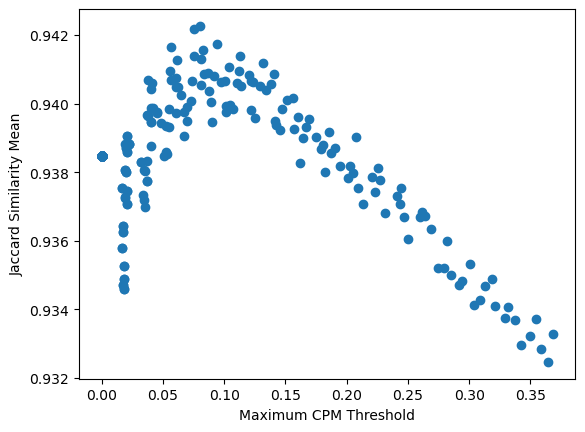

In [32]:
plt.scatter(x=cutoffs, y=jaccard_similarity_means)
plt.xlabel('Maximum CPM Threshold')
plt.ylabel('Jaccard Similarity Mean')
plt.show()

In [33]:
print(np.argmax(jaccard_similarity_means))
print(jaccard_similarity_means[np.argmax(jaccard_similarity_means)])
print(cutoffs[np.argmax(jaccard_similarity_means)])

208
0.9422657533671335
0.08024743659621893


In [34]:
CPM_THRESHOLD = cutoffs[np.argmax(jaccard_similarity_means)]

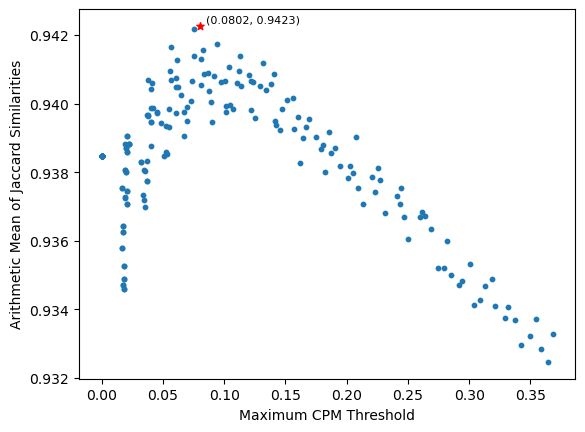

In [35]:
max_index = np.argmax(jaccard_similarity_means)
x_max = cutoffs[max_index]
y_max = jaccard_similarity_means[max_index]

plt.scatter(x=np.delete(cutoffs, max_index), y=np.delete(jaccard_similarity_means, max_index), s=10)

plt.scatter(x=[x_max], y=[y_max], s=30, color='red', marker='*')

label = f'({round(x_max, 4)}, {round(y_max, 4)})'
plt.text(x_max + 0.005, y_max + 0.0001, label, color='black', fontsize=8, ha='left')

plt.xlabel('Maximum CPM Threshold')
plt.ylabel('Arithmetic Mean of Jaccard Similarities')
plt.savefig(f'jaccard_cpm_thresholding.svg', format='svg')
plt.show()

In [36]:
jaccard_fig = bokeh.plotting.figure(
    width=600,
    height=400,
    title='Jaccard similarities of replicates as a function of CPM threshold',
    y_axis_label='Average Jaccard similarity of replicates',
    x_axis_label='CPM Threshold'
)

jaccard_fig.circle(cutoffs, jaccard_similarity_means, alpha=0.3, line_alpha=0.7, size=7)

jaccard_fig.line([0.0802, 0.0802], [0.932, 0.943], color='red')

bokeh.io.show(jaccard_fig)

In [37]:
df_all_cpm['max_cpm'] = df_all_cpm[tpm_cols].apply(lambda x: max(x), axis=1)

In [38]:
df_all_cpm_filtered = df_all_cpm.loc[df_all_cpm['max_cpm'] > CPM_THRESHOLD]
df_all_cpm_filtered.shape, df_all_cpm.shape

((23113, 20), (26687, 20))

In [39]:
df_all_tpm.sample(10)

,TTHERM_ID,000min_A,000min_B,030min_A,030min_B,060min_A,060min_B,090min_A,090min_B,120min_A,120min_B,150min_A,150min_B,180min_A,180min_B,210min_A,210min_B,240min_A,240min_B
15017,TTHERM_00575585,0.112011,0.366847,0.019875,0.227721,0.000000,0.202228,0.015241,0.210936,0.045201,0.151607,0.039919,0.314890,0.033368,0.073358,0.061889,0.112366,0.079193,0.065065
12959,TTHERM_00492680,13.508000,16.910500,13.693000,19.603600,11.467500,16.838400,17.135900,20.061700,27.199000,24.204300,37.634000,28.488700,37.668900,32.342900,24.903800,30.664800,18.790000,25.750500
10892,TTHERM_00423360,0.585029,2.347550,0.773875,1.823560,0.707014,1.467120,0.524881,1.286260,0.729015,1.605970,0.846651,1.981600,0.700101,1.060150,0.469946,0.596255,0.822173,0.757092
10469,TTHERM_00410190,0.008478,0.000000,0.000000,0.025072,0.000000,0.006807,0.009228,0.007986,0.000000,0.000000,0.009664,0.007779,0.000000,0.008081,0.010719,0.000000,0.007382,0.000000
7669,TTHERM_00299729,0.879567,1.086820,0.895842,1.028790,0.986713,1.155320,1.091080,0.986223,0.922264,0.812346,1.091800,0.841847,1.020220,0.822479,1.487670,1.120120,1.163960,1.314350
5532,TTHERM_00218300,0.677155,1.183000,0.582352,1.031520,0.660046,1.273970,0.489156,0.799689,0.430651,0.896047,0.308982,0.887401,0.475152,0.650719,0.551625,0.672652,0.589011,0.549187
23574,TTHERM_01054136,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
13281,TTHERM_00499600,87.060500,95.570100,112.798000,125.860000,100.738000,128.004000,120.134000,132.021000,132.648000,132.143000,123.624000,123.799000,97.742800,104.621000,87.528500,95.107800,104.193000,102.147000
2528,TTHERM_00101245,0.131374,0.208407,0.011328,0.129525,0.000000,0.086432,0.026002,0.067578,0.051365,0.124001,0.068001,0.153277,0.159767,0.148188,0.045425,0.108275,0.072915,0.222155
18236,TTHERM_00703650,3.104550,2.216230,2.241000,1.897380,2.559650,1.875190,2.585220,2.134450,2.580460,2.003160,2.415890,1.809280,2.427700,1.774990,2.638300,2.220410,2.648400,2.200350


In [40]:
df_all_cpm_filtered_plot = df_all_cpm_filtered.iloc[:, 1:]
df_all_cpm_plot = df_all_cpm.iloc[:, 1:]

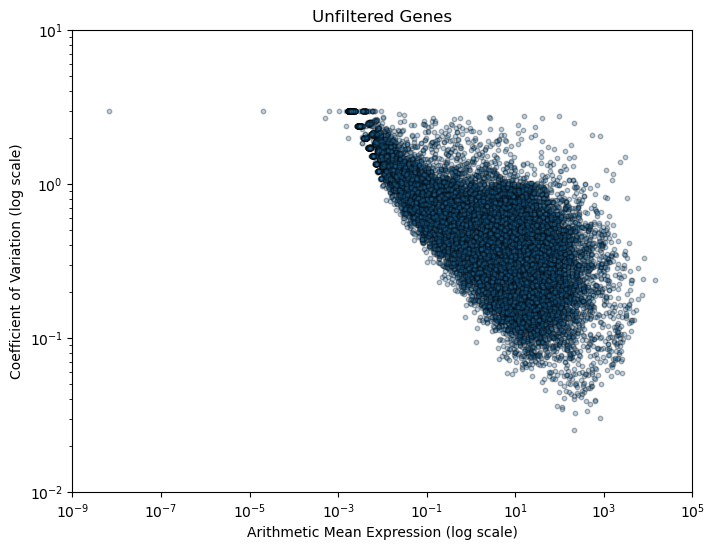

In [41]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate mean and CV
mean_expression = df_all_cpm_plot.mean(axis=1)
std_expression = df_all_cpm_plot.std(axis=1)
cv_expression = std_expression / mean_expression

# Plot CV vs Mean
plt.figure(figsize=(8, 6))
plt.scatter(mean_expression, cv_expression, alpha=0.3, edgecolor='k', s=10)
plt.xscale('log')  # Log scale to handle wide range of mean values
plt.yscale('log')  # Log scale for better visualization of variability
plt.xlabel('Arithmetic Mean Expression (log scale)')
plt.ylabel('Coefficient of Variation (log scale)')
plt.title('Unfiltered Genes')
# plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.xlim(1e-9, 1e5)
plt.ylim(1e-2, 1e1)
plt.savefig(f'jaccard_cpm_uf.svg', format='svg')
plt.show()

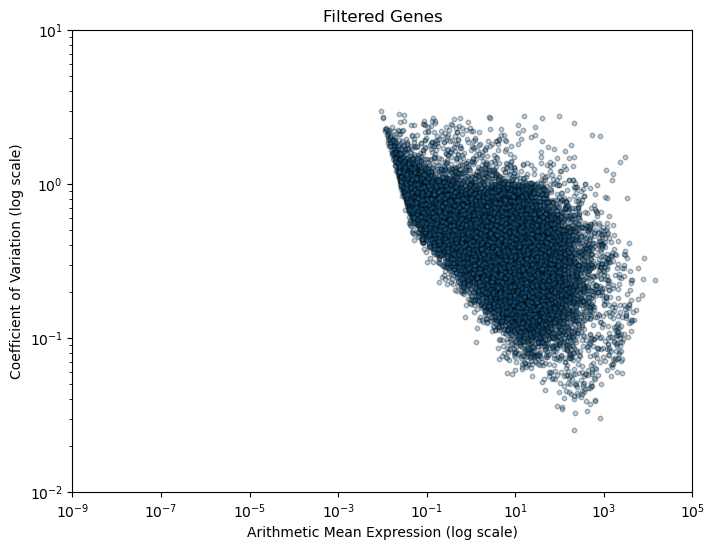

In [42]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate mean and CV
mean_expression = df_all_cpm_filtered_plot.mean(axis=1)
std_expression = df_all_cpm_filtered_plot.std(axis=1)
cv_expression = std_expression / mean_expression

# Plot CV vs Mean
plt.figure(figsize=(8, 6))
plt.scatter(mean_expression, cv_expression, alpha=0.3, edgecolor='k', s=10)
plt.xscale('log')  # Log scale to handle wide range of mean values
plt.yscale('log')  # Log scale for better visualization of variability
plt.xlabel('Arithmetic Mean Expression (log scale)')
plt.ylabel('Coefficient of Variation (log scale)')
plt.title('Filtered Genes')
# plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.xlim(1e-9, 1e5)
plt.ylim(1e-2, 1e1)
plt.savefig(f'jaccard_cpm_f.svg', format='svg')
plt.show()

## Check out genes with all zeros

In [43]:
rows_with_all_zeros = df_all_tpm[(df_all_tpm.iloc[:, 1:] == 0.0).all(axis=1)]

print(rows_with_all_zeros.shape)

rows_with_all_zeros.head()

(1160, 19)


,TTHERM_ID,000min_A,000min_B,030min_A,030min_B,060min_A,060min_B,090min_A,090min_B,120min_A,120min_B,150min_A,150min_B,180min_A,180min_B,210min_A,210min_B,240min_A,240min_B
41,TTHERM_00001455,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
112,TTHERM_00006300,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
119,TTHERM_00006354,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
173,TTHERM_00009840,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
236,TTHERM_00011510,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Check out rows with one nonzero

In [44]:
rows_with_one_nonzero = df_all_tpm[(df_all_tpm.iloc[:, 1:] == 0.0).sum(axis=1) == 17]

print(rows_with_one_nonzero.shape)

rows_with_one_nonzero.head()

(472, 19)


,TTHERM_ID,000min_A,000min_B,030min_A,030min_B,060min_A,060min_B,090min_A,090min_B,120min_A,120min_B,150min_A,150min_B,180min_A,180min_B,210min_A,210min_B,240min_A,240min_B
3,TTHERM_00000031,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.04663,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
135,TTHERM_00007490,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.049759,0.0
332,TTHERM_00013560,0.428543,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
442,TTHERM_00019600,0.000000,0.0,0.006222,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
584,TTHERM_00029970,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.031964,0.0,0.0,0.0,0.0,0.000000,0.0


## Check out the distribution of the number of zeros

In [45]:
num_zeros_counts = {}

for i in range(20):
    num_zeros = (df_all_tpm.iloc[:, 1:] == 0.0).sum(axis=1)
    
    rows_with_num_zeros = df_all_tpm[num_zeros == i]
    
    num_zeros_counts[i] = len(rows_with_num_zeros)

for num_zeros, count in num_zeros_counts.items():
    print(f"Number of rows with {num_zeros} zeros: {count}")

Number of rows with 0 zeros: 20958
Number of rows with 1 zeros: 583
Number of rows with 2 zeros: 349
Number of rows with 3 zeros: 345
Number of rows with 4 zeros: 234
Number of rows with 5 zeros: 236
Number of rows with 6 zeros: 228
Number of rows with 7 zeros: 211
Number of rows with 8 zeros: 186
Number of rows with 9 zeros: 183
Number of rows with 10 zeros: 195
Number of rows with 11 zeros: 177
Number of rows with 12 zeros: 196
Number of rows with 13 zeros: 204
Number of rows with 14 zeros: 204
Number of rows with 15 zeros: 262
Number of rows with 16 zeros: 304
Number of rows with 17 zeros: 472
Number of rows with 18 zeros: 1160
Number of rows with 19 zeros: 0


## Filter out genes with all zeros

In [46]:
df_no_all_zeros = df_all_tpm[~df_all_tpm.isin(rows_with_all_zeros)].dropna()
df_no_all_zeros.reset_index()
print(df_all_tpm.shape[0]-df_no_all_zeros.shape[0])
df_no_all_zeros.head()

1160


,TTHERM_ID,000min_A,000min_B,030min_A,030min_B,060min_A,060min_B,090min_A,090min_B,120min_A,120min_B,150min_A,150min_B,180min_A,180min_B,210min_A,210min_B,240min_A,240min_B
0,TTHERM_00000010,2.392750,0.710646,2.936400,1.481740,0.552868,0.531153,0.187647,0.396045,0.230034,0.328534,0.314569,0.348150,0.453546,0.433522,0.365727,0.498008,0.480000,0.551144
1,TTHERM_00000020,0.065312,0.017114,0.105053,0.025751,0.065452,0.068116,0.092421,0.006149,0.126519,0.045266,0.111743,0.029981,0.031124,0.068427,0.090699,0.052395,0.250010,0.078907
2,TTHERM_00000030,0.306585,0.029759,0.021479,0.000000,0.000000,0.009106,0.024720,0.026718,0.012222,0.014759,0.019432,0.010427,0.010818,0.027029,0.028651,0.005689,0.024687,0.010551
3,TTHERM_00000031,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.046630,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,TTHERM_00000040,2.242310,2.534870,1.450830,1.602540,1.701660,1.871890,1.807760,2.014030,2.020740,2.218700,2.186280,2.399470,1.938510,2.398120,1.824270,1.925910,1.772570,2.160600


In [47]:
df_all_zeros = df_all_tpm[df_all_tpm.isin(rows_with_all_zeros)].dropna()
df_all_zeros.reset_index()
print(df_all_tpm.shape[0]-df_all_zeros.shape[0])
df_all_zeros.head()

25527


,TTHERM_ID,000min_A,000min_B,030min_A,030min_B,060min_A,060min_B,090min_A,090min_B,120min_A,120min_B,150min_A,150min_B,180min_A,180min_B,210min_A,210min_B,240min_A,240min_B
41,TTHERM_00001455,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
112,TTHERM_00006300,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
119,TTHERM_00006354,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
173,TTHERM_00009840,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
236,TTHERM_00011510,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [48]:
df_no_all_zeros.shape

(25527, 19)

## Check out the genes which display the highest expression

In [49]:
[np.max(df_no_all_zeros[col]) for col in list(df_no_all_zeros.columns)[1:]]

[28942.1,
 40870.4,
 31016.2,
 45994.6,
 31964.5,
 44656.7,
 31242.3,
 39961.5,
 30575.7,
 41728.1,
 31284.7,
 46152.2,
 33897.7,
 32471.1,
 30873.1,
 31104.1,
 32780.3,
 31424.2]

In [50]:
max_tpm_ttherms = []

for col in df_no_all_zeros.columns[1:]:
    max_tpm = df_no_all_zeros[col].max()
    max_tpm_ttherm = df_no_all_zeros['TTHERM_ID'].loc[df_no_all_zeros[col] == df_no_all_zeros[col].max()].values[0]
    print(col, 'MAX:', max_tpm, '|', max_tpm_ttherm)
    max_tpm_ttherms.append(max_tpm_ttherm)
    

000min_A MAX: 28942.1 | TTHERM_01068180
000min_B MAX: 40870.4 | TTHERM_00526400
030min_A MAX: 31016.2 | TTHERM_01068180
030min_B MAX: 45994.6 | TTHERM_00760295
060min_A MAX: 31964.5 | TTHERM_01068180
060min_B MAX: 44656.7 | TTHERM_00760295
090min_A MAX: 31242.3 | TTHERM_01068180
090min_B MAX: 39961.5 | TTHERM_00526400
120min_A MAX: 30575.7 | TTHERM_01068180
120min_B MAX: 41728.1 | TTHERM_00526400
150min_A MAX: 31284.7 | TTHERM_01068180
150min_B MAX: 46152.2 | TTHERM_00526400
180min_A MAX: 33897.7 | TTHERM_01068180
180min_B MAX: 32471.1 | TTHERM_00526400
210min_A MAX: 30873.1 | TTHERM_01068180
210min_B MAX: 31104.1 | TTHERM_01068180
240min_A MAX: 32780.3 | TTHERM_01068180
240min_B MAX: 31424.2 | TTHERM_01068180


In [51]:
np.unique(max_tpm_ttherms)

array(['TTHERM_00526400', 'TTHERM_00760295', 'TTHERM_01068180'],
      dtype='<U15')

# FILTER OUT GENES IN THE TPM DATAFRAME

In [52]:
df_filtered = df_all_tpm.loc[df_all_tpm['TTHERM_ID'].isin(df_all_cpm_filtered['TTHERM_ID'].values)]

In [53]:
df_filtered.shape, df_no_all_zeros.shape, df_all_tpm.shape

((23113, 19), (25527, 19), (26687, 19))

In [54]:
df_filtered.loc[df_filtered['TTHERM_ID'].isin(df_all_zeros['TTHERM_ID'].values)]

,TTHERM_ID,000min_A,000min_B,030min_A,030min_B,060min_A,060min_B,090min_A,090min_B,120min_A,120min_B,150min_A,150min_B,180min_A,180min_B,210min_A,210min_B,240min_A,240min_B


In [55]:
df_filtered.head()

,TTHERM_ID,000min_A,000min_B,030min_A,030min_B,060min_A,060min_B,090min_A,090min_B,120min_A,120min_B,150min_A,150min_B,180min_A,180min_B,210min_A,210min_B,240min_A,240min_B
0,TTHERM_00000010,2.392750,0.710646,2.936400,1.481740,0.552868,0.531153,0.187647,0.396045,0.230034,0.328534,0.314569,0.348150,0.453546,0.433522,0.365727,0.498008,0.480000,0.551144
1,TTHERM_00000020,0.065312,0.017114,0.105053,0.025751,0.065452,0.068116,0.092421,0.006149,0.126519,0.045266,0.111743,0.029981,0.031124,0.068427,0.090699,0.052395,0.250010,0.078907
2,TTHERM_00000030,0.306585,0.029759,0.021479,0.000000,0.000000,0.009106,0.024720,0.026718,0.012222,0.014759,0.019432,0.010427,0.010818,0.027029,0.028651,0.005689,0.024687,0.010551
4,TTHERM_00000040,2.242310,2.534870,1.450830,1.602540,1.701660,1.871890,1.807760,2.014030,2.020740,2.218700,2.186280,2.399470,1.938510,2.398120,1.824270,1.925910,1.772570,2.160600
5,TTHERM_00000047,0.124883,0.061840,0.133771,0.143597,0.162613,0.186829,0.412327,0.489517,0.985978,0.689203,1.834060,0.703661,1.902240,1.069510,0.618985,1.033190,0.209819,0.622642


In [56]:
[np.max(df_filtered[col]) for col in tpm_cols]

[28942.1,
 40870.4,
 31016.2,
 45994.6,
 31964.5,
 44656.7,
 31242.3,
 39961.5,
 30575.7,
 41728.1,
 31284.7,
 46152.2,
 33897.7,
 32471.1,
 30873.1,
 31104.1,
 32780.3,
 31424.2]

# Filter out genes with all zeros

In [57]:
df_filtered_with_all_zeros = df_filtered[(df_filtered.iloc[:, 1:] == 0.0).all(axis=1)]

print(df_filtered_with_all_zeros.shape)

df_filtered_with_all_zeros.head()

(0, 19)


,TTHERM_ID,000min_A,000min_B,030min_A,030min_B,060min_A,060min_B,090min_A,090min_B,120min_A,120min_B,150min_A,150min_B,180min_A,180min_B,210min_A,210min_B,240min_A,240min_B


In [58]:
df_filtered_no_all_zeros = df_filtered[~df_filtered.isin(df_filtered_with_all_zeros)].dropna()
df_filtered_no_all_zeros.reset_index()
print(df_filtered.shape[0])
print(df_filtered_no_all_zeros.shape[0])
print(df_filtered.shape[0]-df_filtered_no_all_zeros.shape[0])
df_filtered_no_all_zeros.head()

23113
23113
0


,TTHERM_ID,000min_A,000min_B,030min_A,030min_B,060min_A,060min_B,090min_A,090min_B,120min_A,120min_B,150min_A,150min_B,180min_A,180min_B,210min_A,210min_B,240min_A,240min_B
0,TTHERM_00000010,2.392750,0.710646,2.936400,1.481740,0.552868,0.531153,0.187647,0.396045,0.230034,0.328534,0.314569,0.348150,0.453546,0.433522,0.365727,0.498008,0.480000,0.551144
1,TTHERM_00000020,0.065312,0.017114,0.105053,0.025751,0.065452,0.068116,0.092421,0.006149,0.126519,0.045266,0.111743,0.029981,0.031124,0.068427,0.090699,0.052395,0.250010,0.078907
2,TTHERM_00000030,0.306585,0.029759,0.021479,0.000000,0.000000,0.009106,0.024720,0.026718,0.012222,0.014759,0.019432,0.010427,0.010818,0.027029,0.028651,0.005689,0.024687,0.010551
4,TTHERM_00000040,2.242310,2.534870,1.450830,1.602540,1.701660,1.871890,1.807760,2.014030,2.020740,2.218700,2.186280,2.399470,1.938510,2.398120,1.824270,1.925910,1.772570,2.160600
5,TTHERM_00000047,0.124883,0.061840,0.133771,0.143597,0.162613,0.186829,0.412327,0.489517,0.985978,0.689203,1.834060,0.703661,1.902240,1.069510,0.618985,1.033190,0.209819,0.622642


In [59]:
df_filtered_no_all_zeros

,TTHERM_ID,000min_A,000min_B,030min_A,030min_B,060min_A,060min_B,090min_A,090min_B,120min_A,120min_B,150min_A,150min_B,180min_A,180min_B,210min_A,210min_B,240min_A,240min_B
0,TTHERM_00000010,2.392750,0.710646,2.936400,1.481740,0.552868,0.531153,0.187647,0.396045,0.230034,0.328534,0.314569,0.348150,0.453546,0.433522,0.365727,0.498008,0.480000,0.551144
1,TTHERM_00000020,0.065312,0.017114,0.105053,0.025751,0.065452,0.068116,0.092421,0.006149,0.126519,0.045266,0.111743,0.029981,0.031124,0.068427,0.090699,0.052395,0.250010,0.078907
2,TTHERM_00000030,0.306585,0.029759,0.021479,0.000000,0.000000,0.009106,0.024720,0.026718,0.012222,0.014759,0.019432,0.010427,0.010818,0.027029,0.028651,0.005689,0.024687,0.010551
4,TTHERM_00000040,2.242310,2.534870,1.450830,1.602540,1.701660,1.871890,1.807760,2.014030,2.020740,2.218700,2.186280,2.399470,1.938510,2.398120,1.824270,1.925910,1.772570,2.160600
5,TTHERM_00000047,0.124883,0.061840,0.133771,0.143597,0.162613,0.186829,0.412327,0.489517,0.985978,0.689203,1.834060,0.703661,1.902240,1.069510,0.618985,1.033190,0.209819,0.622642
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26680,TTHERM_02653503,0.980579,3.725720,1.413220,5.371690,1.881150,5.763860,2.128700,6.852220,2.505580,6.086270,1.529360,5.320890,0.955522,3.204800,0.493389,3.701870,2.277960,3.124150
26681,TTHERM_02653508,8.679450,15.797800,9.162470,14.646200,12.037900,16.883000,14.161500,17.241900,11.999300,18.251500,10.362000,17.859500,7.809500,13.069300,8.018720,9.962080,9.153860,9.997680
26683,TTHERM_02653516,1.048350,0.986232,0.594687,0.859194,0.300709,0.602789,0.237124,0.539547,0.219536,0.766409,0.309892,0.562066,0.234399,0.559173,0.432144,0.508124,0.570547,0.646110
26684,TTHERM_02653518,1.432380,1.241940,1.223780,1.402420,0.786592,0.988750,0.620208,0.935363,0.727973,0.760378,0.710016,0.769129,0.762623,0.820501,0.943048,1.074950,1.211450,1.165040


In [60]:
df_filtered_no_all_zeros[df_filtered_no_all_zeros.isna().any(axis=1)]

,TTHERM_ID,000min_A,000min_B,030min_A,030min_B,060min_A,060min_B,090min_A,090min_B,120min_A,120min_B,150min_A,150min_B,180min_A,180min_B,210min_A,210min_B,240min_A,240min_B


In [61]:
df_filtered_no_all_zeros.sample(10)

,TTHERM_ID,000min_A,000min_B,030min_A,030min_B,060min_A,060min_B,090min_A,090min_B,120min_A,120min_B,150min_A,150min_B,180min_A,180min_B,210min_A,210min_B,240min_A,240min_B
6912,TTHERM_00270360,1.110140,1.446450,0.667499,1.113370,0.731659,1.030510,0.779081,0.985039,1.069260,1.168910,1.422450,1.225390,1.497730,1.181790,1.332170,1.457860,1.257120,1.293850
15128,TTHERM_00578720,4.932500,7.604580,8.814860,11.921900,11.476100,18.444300,25.156500,25.621300,42.219300,34.805900,52.476800,40.248900,35.336900,39.252200,14.464900,26.958500,12.258300,19.019800
12816,TTHERM_00488350,19.982100,16.164700,20.834300,18.264600,17.451100,15.372100,17.454800,15.436300,16.660600,14.368300,20.217600,13.972100,24.620700,17.912100,27.309000,22.348500,26.702000,23.203200
6476,TTHERM_00251110,0.064906,0.075524,0.030765,0.106648,0.000000,0.104333,0.011776,0.050990,0.011633,0.056173,0.073937,0.069438,0.020662,0.051602,0.041108,0.054433,0.047149,0.050297
13839,TTHERM_00529930,0.117576,0.333181,0.026933,0.059695,0.003568,0.017128,0.007756,0.010053,0.000000,0.003089,0.000000,0.016369,0.003391,0.006779,0.000000,0.010692,0.018572,0.006620
2702,TTHERM_00107020,0.453327,0.907335,0.385347,0.774873,0.316230,0.699511,0.212369,0.518497,0.247054,0.517115,0.327336,0.616518,0.497499,0.448026,0.441635,0.529042,0.464108,0.538560
16471,TTHERM_00636910,0.319931,0.445207,0.550515,0.378707,0.644368,0.336779,0.348214,0.515743,0.514188,0.633575,0.361777,0.466867,0.616332,0.276651,0.286670,0.261295,0.759787,0.478050
14344,TTHERM_00545810,2.532820,1.553600,4.171460,2.917710,3.092660,2.424370,1.728840,2.130330,1.993660,2.226940,2.619100,2.011140,3.292120,2.511650,2.668710,2.442050,2.082940,2.417180
15286,TTHERM_00582300,0.162776,0.408288,0.471701,0.600348,0.594454,1.060980,0.262913,0.588031,0.146955,0.468691,0.119829,0.376147,0.125036,0.239935,0.397343,0.252471,0.493068,0.361043
7144,TTHERM_00283660,5.921610,2.295110,5.457730,2.469360,5.138550,2.821940,5.549840,2.718600,5.789450,3.855050,5.861710,3.930630,5.464180,4.370930,6.381050,4.437720,5.719990,4.673930


In [62]:
df_filtered_no_all_zeros_plot = df_filtered_no_all_zeros.iloc[:, 1:]
df_all_tpm_plot = df_all_tpm.iloc[:, 1:]

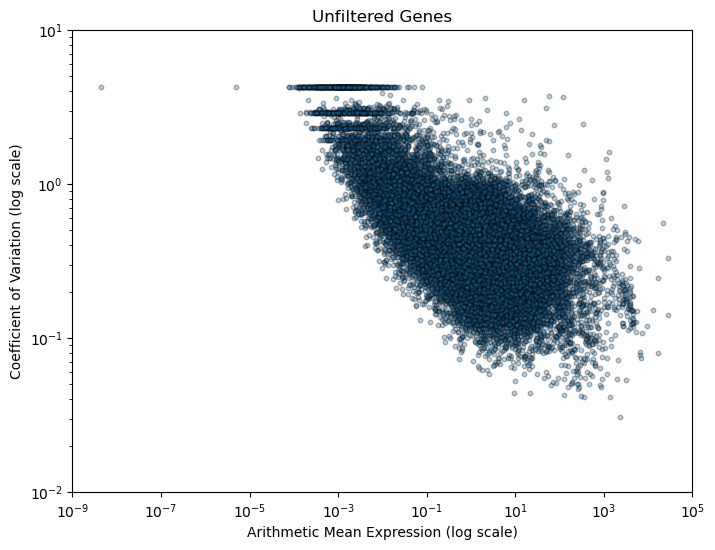

In [63]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate mean and CV
mean_expression = df_all_tpm_plot.mean(axis=1)
std_expression = df_all_tpm_plot.std(axis=1)
cv_expression = std_expression / mean_expression

# Plot CV vs Mean
plt.figure(figsize=(8, 6))
plt.scatter(mean_expression, cv_expression, alpha=0.3, edgecolor='k', s=10)
plt.xscale('log')  # Log scale to handle wide range of mean values
plt.yscale('log')  # Log scale for better visualization of variability
plt.xlabel('Arithmetic Mean Expression (log scale)')
plt.ylabel('Coefficient of Variation (log scale)')
plt.title('Unfiltered Genes')
# plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.xlim(1e-9, 1e5)
plt.ylim(1e-2, 1e1)
plt.savefig(f'jaccard_tpm_uf.svg', format='svg')
plt.show()

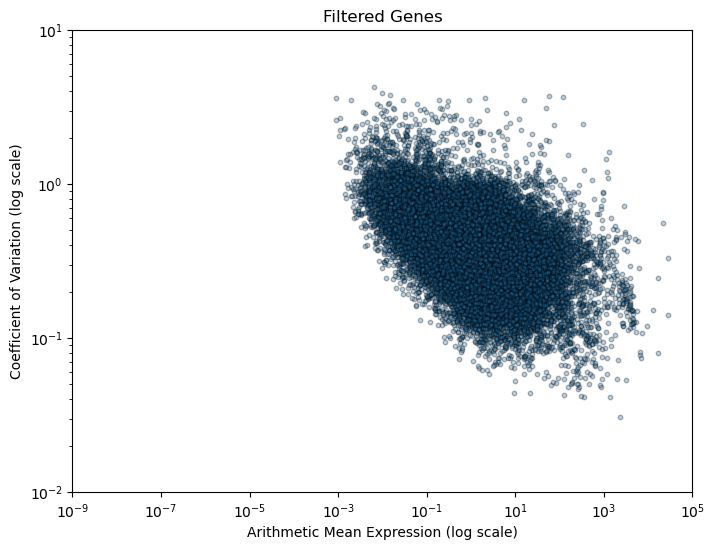

In [64]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate mean and CV
mean_expression = df_filtered_no_all_zeros_plot.mean(axis=1)
std_expression = df_filtered_no_all_zeros_plot.std(axis=1)
cv_expression = std_expression / mean_expression

# Plot CV vs Mean
plt.figure(figsize=(8, 6))
plt.scatter(mean_expression, cv_expression, alpha=0.3, edgecolor='k', s=10)
plt.xscale('log')  # Log scale to handle wide range of mean values
plt.yscale('log')  # Log scale for better visualization of variability
plt.xlabel('Arithmetic Mean Expression (log scale)')
plt.ylabel('Coefficient of Variation (log scale)')
plt.title('Filtered Genes')
# plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.xlim(1e-9, 1e5)
plt.ylim(1e-2, 1e1)
plt.savefig(f'jaccard_tpm_f.svg', format='svg')
plt.show()

In [65]:
df_filtered_no_all_zeros_plot.head()

,000min_A,000min_B,030min_A,030min_B,060min_A,060min_B,090min_A,090min_B,120min_A,120min_B,150min_A,150min_B,180min_A,180min_B,210min_A,210min_B,240min_A,240min_B
0,2.392750,0.710646,2.936400,1.481740,0.552868,0.531153,0.187647,0.396045,0.230034,0.328534,0.314569,0.348150,0.453546,0.433522,0.365727,0.498008,0.480000,0.551144
1,0.065312,0.017114,0.105053,0.025751,0.065452,0.068116,0.092421,0.006149,0.126519,0.045266,0.111743,0.029981,0.031124,0.068427,0.090699,0.052395,0.250010,0.078907
2,0.306585,0.029759,0.021479,0.000000,0.000000,0.009106,0.024720,0.026718,0.012222,0.014759,0.019432,0.010427,0.010818,0.027029,0.028651,0.005689,0.024687,0.010551
4,2.242310,2.534870,1.450830,1.602540,1.701660,1.871890,1.807760,2.014030,2.020740,2.218700,2.186280,2.399470,1.938510,2.398120,1.824270,1.925910,1.772570,2.160600
5,0.124883,0.061840,0.133771,0.143597,0.162613,0.186829,0.412327,0.489517,0.985978,0.689203,1.834060,0.703661,1.902240,1.069510,0.618985,1.033190,0.209819,0.622642


In [66]:
from bokeh.models import Range1d
def plot_tpms(nonzero_expr_df, title=None, y_axis_label=None, x_axis_label=None):
    mean_expression = nonzero_expr_df.mean(axis=1)
    std_expression = nonzero_expr_df.std(axis=1)
    cv_expression = std_expression / mean_expression

    tpm_fig = bokeh.plotting.figure(
        height=400,
        width=600,
        title=title,
        y_axis_label=y_axis_label,
        x_axis_label=x_axis_label,
        y_axis_type='log',
        x_axis_type='log'
    )

    tpm_fig.circle(mean_expression, cv_expression, alpha=0.05, line_alpha=0.7)

    tpm_fig.x_range = Range1d(1e-12, 1e5)
    tpm_fig.y_range = Range1d(1e-2, 10)

    # bokeh.io.show(tpm_fig)

    

    return tpm_fig



In [67]:
filt_tpms_plot = plot_tpms(df_filtered_no_all_zeros_plot, title='After Jaccard Filtering', x_axis_label='Mean Transcripts per Million per Gene', y_axis_label='Coefficient of Variation')

In [68]:
all_tpms_plot = plot_tpms(df_all_tpm_plot, title='Before Jaccard Filtering', x_axis_label='Mean Transcripts per Million per Gene', y_axis_label='Coefficient of Variation')

In [69]:
bokeh.io.show(bokeh.plotting.column([all_tpms_plot, filt_tpms_plot]))

In [70]:
df_all_cpm.head()

,TTHERM_ID,000min_A,000min_B,030min_A,030min_B,060min_A,060min_B,090min_A,090min_B,120min_A,120min_B,150min_A,150min_B,180min_A,180min_B,210min_A,210min_B,240min_A,240min_B,max_cpm
0,TTHERM_00000010,6.176870,2.213916,7.857422,4.485889,1.510879,1.661307,0.520730,1.236706,0.624212,1.006802,0.810371,1.103402,1.165294,1.231530,0.941152,1.325002,1.299130,1.502907,7.857422
1,TTHERM_00000020,0.178008,0.056286,0.296836,0.082310,0.188860,0.224969,0.270779,0.020274,0.362446,0.146444,0.303889,0.100309,0.084442,0.205255,0.246492,0.147222,0.714522,0.227184,0.714522
2,TTHERM_00000030,0.961242,0.112572,0.069844,0.000000,0.000000,0.034611,0.083317,0.101369,0.040272,0.054916,0.060778,0.040124,0.033777,0.093298,0.089633,0.018403,0.081196,0.034951,0.961242
3,TTHERM_00000031,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.018305,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.018305
4,TTHERM_00000040,11.463702,15.628746,7.700274,9.609679,9.216359,11.611846,9.935524,12.468427,10.853234,13.454530,11.142597,15.046394,9.879665,13.509511,9.321882,10.176749,9.516130,11.673741,15.628746


In [71]:
tidy_all_cpm_df = df_all_cpm.melt(id_vars='TTHERM_ID', var_name='replicate', value_name='counts')
tidy_all_cpm_df.head()

,TTHERM_ID,replicate,counts
0,TTHERM_00000010,000min_A,6.176870
1,TTHERM_00000020,000min_A,0.178008
2,TTHERM_00000030,000min_A,0.961242
3,TTHERM_00000031,000min_A,0.000000
4,TTHERM_00000040,000min_A,11.463702


In [72]:
df_all_cpm_filtered.head()

,TTHERM_ID,000min_A,000min_B,030min_A,030min_B,060min_A,060min_B,090min_A,090min_B,120min_A,120min_B,150min_A,150min_B,180min_A,180min_B,210min_A,210min_B,240min_A,240min_B,max_cpm
0,TTHERM_00000010,6.176870,2.213916,7.857422,4.485889,1.510879,1.661307,0.520730,1.236706,0.624212,1.006802,0.810371,1.103402,1.165294,1.231530,0.941152,1.325002,1.299130,1.502907,7.857422
1,TTHERM_00000020,0.178008,0.056286,0.296836,0.082310,0.188860,0.224969,0.270779,0.020274,0.362446,0.146444,0.303889,0.100309,0.084442,0.205255,0.246492,0.147222,0.714522,0.227184,0.714522
2,TTHERM_00000030,0.961242,0.112572,0.069844,0.000000,0.000000,0.034611,0.083317,0.101369,0.040272,0.054916,0.060778,0.040124,0.033777,0.093298,0.089633,0.018403,0.081196,0.034951,0.961242
4,TTHERM_00000040,11.463702,15.628746,7.700274,9.609679,9.216359,11.611846,9.935524,12.468427,10.853234,13.454530,11.142597,15.046394,9.879665,13.509511,9.321882,10.176749,9.516130,11.673741,15.628746
5,TTHERM_00000047,0.534023,0.318954,0.593672,0.720212,0.736553,0.969096,1.895456,2.534233,4.429891,3.496347,7.820077,3.691382,8.106392,5.038077,2.644188,4.563895,0.941870,2.813581,8.106392


In [73]:
tidy_cpm_filtered_df = df_all_cpm_filtered.melt(id_vars='TTHERM_ID', var_name='replicate', value_name='counts')
# tidy_cpm_filtered_df = tidy_cpm_filtered_df[tidy_cpm_filtered_df.columns[1:]]
tidy_cpm_filtered_df.head()

,TTHERM_ID,replicate,counts
0,TTHERM_00000010,000min_A,6.176870
1,TTHERM_00000020,000min_A,0.178008
2,TTHERM_00000030,000min_A,0.961242
3,TTHERM_00000040,000min_A,11.463702
4,TTHERM_00000047,000min_A,0.534023


In [74]:

all_ttids = set(tidy_all_cpm_df['TTHERM_ID'].unique())
kept_ttids = set(tidy_cpm_filtered_df['TTHERM_ID'].unique())

lost_ttids = all_ttids - kept_ttids
len(lost_ttids)

3574

In [75]:
colors = []
labels = []
for ttid in tqdm.tqdm(tidy_all_cpm_df['TTHERM_ID'].values):
    if ttid in lost_ttids:
        colors.append('red')
        labels.append('lost')
    else: 
        colors.append('blue')
        labels.append('kept')

tidy_all_cpm_df['color'] = colors
tidy_all_cpm_df['label'] = labels

100%|██████████████████████████████████████████████████| 507053/507053 [00:00<00:00, 3368246.51it/s]


In [76]:
tidy_all_cpm_df.head()

,TTHERM_ID,replicate,counts,color,label
0,TTHERM_00000010,000min_A,6.176870,blue,kept
1,TTHERM_00000020,000min_A,0.178008,blue,kept
2,TTHERM_00000030,000min_A,0.961242,blue,kept
3,TTHERM_00000031,000min_A,0.000000,red,lost
4,TTHERM_00000040,000min_A,11.463702,blue,kept


In [77]:
len(tidy_cpm_filtered_df)

439147

In [78]:
np.max(tidy_cpm_filtered_df['counts'])

18809.116023372095

In [79]:
len(tidy_cpm_filtered_df.loc[tidy_cpm_filtered_df['replicate'] == '000min_A'])

23113

In [80]:
np.max(tidy_all_cpm_df['counts'].values)

18809.116023372095

In [81]:
np.max(tidy_cpm_filtered_df['counts'].values)

18809.116023372095

In [82]:
np.min(tidy_all_cpm_df.loc[tidy_all_cpm_df['counts'] > 0]['counts'].values)

1.5898988088829168e-10

In [83]:
np.min(tidy_cpm_filtered_df.loc[tidy_cpm_filtered_df['counts'] > 0]['counts'].values)

1.882431984333983e-10

In [84]:
cpm_filtered_expression_plot = expression_jitter_plot(tidy_cpm_filtered_df, 
                                                      title='filtered CPMs', 
                                                      y_max=1e5,
                                                      width=800,
                                                      jitter_width=0.8
                                                     )
cpm_all_expression_plot = expression_jitter_plot(tidy_all_cpm_df, 
                                                 title='Jaccard Filter of CPMs', 
                                                 y_max=1e5,
                                                 width=800,
                                                 jitter_width=0.8,
                                                 y_axis_label='Counts Per Million',
                                                 x_axis_label='Replicate Condition'
                                                )

In [85]:
bokeh.io.show(cpm_all_expression_plot)

# Export the filtered TPM data to CSV

In [86]:
df_filtered_no_all_zeros.to_csv('../../active_files/rna_seq.csv', index=False)